In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1_101-all-classes.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "All-classes-Full-UTK-CE_ResNet34-100%-EPOCHS-200-withoutLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 101
BATCH_SIZE = 256
EPOCHS = 200
learning_rate = 0.0005
NUM_WORKERS = 0

In [ ]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-09-10 16:58:16.737511+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: False
Using CUDA device: cpu
Random Seed: 42
NUM WORKERS: 0
Model Name: All-classes-Full-UTK-CE_ResNet34-100%-EPOCHS-200-withoutLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/All-classes-Full-UTK-CE_ResNet34-100%-EPOCHS-200-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 256
Grayscale: False
Learning Rate: 0.0005
Epochs: 200


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [ ]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label-CE'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# Dataset Entity Distribution Analysis

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

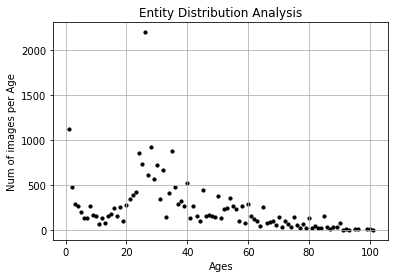

label		Age		Count
0 		 1 		 1123
1 		 2 		 482
2 		 3 		 289
3 		 4 		 273
4 		 5 		 196
5 		 6 		 131
6 		 7 		 139
7 		 8 		 263
8 		 9 		 166
9 		 10 		 156
10 		 11 		 65
11 		 12 		 130
12 		 13 		 81
13 		 14 		 157
14 		 15 		 177
15 		 16 		 247
16 		 17 		 158
17 		 18 		 262
18 		 19 		 98
19 		 20 		 284
20 		 21 		 346
21 		 22 		 395
22 		 23 		 426
23 		 24 		 859
24 		 25 		 734
25 		 26 		 2197
26 		 27 		 615
27 		 28 		 918
28 		 29 		 570
29 		 30 		 724
30 		 31 		 350
31 		 32 		 664
32 		 33 		 143
33 		 34 		 409
34 		 35 		 880
35 		 36 		 483
36 		 37 		 293
37 		 38 		 325
38 		 39 		 266
39 		 40 		 526
40 		 41 		 132
41 		 42 		 266
42 		 43 		 157
43 		 44 		 100
44 		 45 		 440
45 		 46 		 153
46 		 47 		 170
47 		 48 		 153
48 		 49 		 148
49 		 50 		 381
50 		 51 		 138
51 		 52 		 232
52 		 53 		 241
53 		 54 		 353
54 		 55 		 268
55 		 56 		 236
56 		 57 		 97
57 		 58 		 271
58 		 59 		 82
59 		 60 		 293
60 		 61 		 161
61 		 62 		 125
62 		 63 		 

In [ ]:
dataset_analysis(train_dataset)

# Dataset Loader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [ ]:
len(train_loader)

93

# Model

`nn.RELU(inplace=True)` [details](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)

Understanding the underscore( _ ) of Python [link](https://stackoverflow.com/questions/8689964/why-do-some-functions-have-underscores-before-and-after-the-function-name)

`self.modules()` [link](https://discuss.pytorch.org/t/pytorch-self-module/49677)

What do `*` and `**` before a variable name mean in a function signature? [link](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # reshaping, -1 means calculate the suitable number for second dimension 
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

# Initialise Model & Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0
 
  model.train()
  train_mae=0.0
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):
      targets, features =  targets.to(DEVICE), features.to(DEVICE)

      # FORWARD AND BACK PROP
      logits, probas = model(features)
      cost = F.cross_entropy(logits, targets)
      _, predicted_labels = torch.max(probas, dim=1)

      optimizer.zero_grad()
      cost.backward()

      # UPDATE MODEL PARAMETERS
      optimizer.step()
      
      train_total_num_correct_preds += calculate_correct_preds(probas, targets)
      train_num_examples += targets.size(0) 
      train_mae += torch.sum(torch.abs(predicted_labels - targets))

  train_mae = train_mae/train_num_examples

  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  model_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, model_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

# Evaluation

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)
    
    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

# Saving the Model

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [ ]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))